# Análisis de los resultados

Algunas preguntas surgen al realizar el estudio. Hasta el momento nos hemos preguntado:

1. ¿Cómo es el consumo de energía si se utiliza un termostato convencional?
2. ¿Cómo es el confort cuando se utiliza un termostato convencional?
3. ¿Cómo afecta la política al control de sombras convencional?
4. ¿Cómo sería el confort cuando no hay sistema de calefacción? ¿mejora con respecto al convencional?

Intentaremos responder a continuación a éstas con un análisis en profundidad de los datos.

## Importación de datos

Los archivos de datos utilizados para la evaluación del rendimiento de la política entrenada se generan a partir de los programas de evaluación que se introducen en los archivos `init_conventional.py` y `init_evaluation.py`. El primero aplica las políticas convencionales o basadas en reglas (RB) al caso evaluado, mientras que el segundo hace lo mismo pero aplicando la política entrenada con algoritmos de DRL.

Para responder a las preguntas realizadas, diferentes escenarios son evaluados (todos los escenarios se evaluan con un archivo climático distinto a los utilizados durante el entrenamiento):

1. ¿Cómo es el consumo de energía si se utiliza un termostato convencional?
    * Se plantea un escenario igual al entrenado, pero el termostato se modifica para calcular el requerimiento energético para un seteo de temperatura en vez de confort.
2. ¿Cómo es el confort cuando se utiliza un termostato convencional?
    * Al igual que en el punto anterior, se utiliza el mismo entorno para la evaluación, pero se modifica el flujo de EPRunner y EPEnv para poder incluir la métrica PPD, lo cual no se hizo durante el entrenamiento. Esto no afecta a la política entrenada previamente.
3. ¿Cómo afecta la política al control de sombras convencional?
    * Se continúa utilizando el mismo entorno de evaluación, pero ahora se centra la atención en la operación de las persianas, que se ven modificadas por la influencia del comportamiento del agente.
4. ¿Cómo sería el confort cuando no hay sistema de calefacción? ¿mejora con respecto al convencional?
    * Aquí se debe incluir un escenario en el que el sistema ideal de HVAC se encuentra no disponible, por lo que se evalúa el comportamiento natural del edificio.

### Escenario 1: Termostato convencional

Se evalúa un escenario con un equipo ideal de HVAC que utiliza un termostato basado en temperaturas de referencia. En nuestro caso, 19 °C como límite inferior y 24 °C como límite superior. Fuera de ese rango, la calefacción o refrigeración es necesaria.

Se comienza importando los datos del escenario a analizar:

In [9]:
# Import the necesaty libraries
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'ppo_file_path' and 'rb_file_path' with the actual paths to your CSV files
drl_file_path = "C:/Users/grhen/Documents/Resultados_RLforEP/prot3_drl/prot3_drl.csv"
drl2_file_path = "C:/Users/grhen/Documents/Resultados_RLforEP/prot3_drl_4/prot3_drl_4.csv"
rb_file_path = "C:/Users/grhen/Documents/Resultados_RLforEP/prot3_rb/prot3_rb.csv"
novent_file_path = "C:/Users/grhen/Documents/Resultados_RLforEP/prot3_novent/prot3_novent.csv"

# Read CSV files into pandas DataFrames
drl_data = pd.read_csv(drl_file_path, header=None)
drl2_data = pd.read_csv(drl_file_path, header=None)
rb_data = pd.read_csv(rb_file_path, header=None)
novent_data = pd.read_csv(novent_file_path, header=None)

# Function to clean and format the data
def clean_and_format(data: pd.DataFrame):
    # Remove empty rows
    data = data.dropna(how='all')
    
    obs_list = [
        "Agent Indicator",
        "Site Outdoor Air Drybulb Temperature","Zone Mean Air Temperature","Site Wind Speed",
        "Site Wind Direction","Site Outdoor Air Relative Humidity","Zone Air Relative Humidity",
        "Site Outdoor Air Barometric Pressure","Zone People Occupant Count",
        "Electricity:Zone:THERMAL ZONE: LIVING","NaturalGas:Zone:THERMAL ZONE: LIVING",
        "AirFlow Network Window/Door Opening: room1_N_window",
        "AirFlow Network Window/Door Opening: room1_S_window",
        'day_of_the_week','is_raining','sun_is_up','hora','simulation_day',"rad",
    ]
    
    prediction_obs_list = []
    predicted_variables = [
        "Dry Bulb Temperature",
        "Relative Humidity",
        "Wind Direction",
        "Wind Speed",
        "Total Sky",
        "Liquid Precipitation Depth"
    ]
    number_of_days_predicted = 2
    for day in range(number_of_days_predicted):
        for hour in range(24):
            for pv in range(len(predicted_variables)):
                prediction_obs_list.append(predicted_variables[pv]+' day '+str(day)+' hour '+str(hour))
    
    action_list = [
        'window_opening_1',
        'window_opening_2'
    ]
    
    learning_list = [
        'reward',
        'terminated',
        'truncated'
    ]
    
    infos_list = [
        "Zone Thermal Comfort Fanger Model PPD",
        "Zone Mean Air Temperature (infos)",
        "occupancy"
    ]
    
    header = obs_list + prediction_obs_list + action_list + learning_list + infos_list
    
    data.columns = header

    return data

def clean_and_format_rb(data: pd.DataFrame):
    # Remove empty rows
    data = data.dropna(how='all')
    
    obs_list = [
        "Agent Indicator",
        "Site Outdoor Air Drybulb Temperature","Zone Mean Air Temperature","Site Wind Speed",
        "Site Wind Direction","Site Outdoor Air Relative Humidity","Zone Air Relative Humidity",
        "Site Outdoor Air Barometric Pressure","Zone People Occupant Count",
        "Electricity:Zone:THERMAL ZONE: LIVING","NaturalGas:Zone:THERMAL ZONE: LIVING",
        "AirFlow Network Window/Door Opening: room1_N_window",
        "AirFlow Network Window/Door Opening: room1_S_window",
        'day_of_the_week','is_raining','sun_is_up','hora','simulation_day',"rad",
    ]
    
    prediction_obs_list = []
    predicted_variables = [
        "Dry Bulb Temperature",
        "Relative Humidity",
        "Wind Direction",
        "Wind Speed",
        "Total Sky",
        "Liquid Precipitation Depth"
    ]
    number_of_days_predicted = 2
    for day in range(number_of_days_predicted):
        for hour in range(24):
            for pv in range(len(predicted_variables)):
                prediction_obs_list.append(predicted_variables[pv]+' day '+str(day)+' hour '+str(hour))
    
    action_list = [
        'window_opening_1',
        'window_opening_2'
    ]
    
    learning_list = [
        'reward',
        'terminated',
        'truncated'
    ]
    
    infos_list = [
        "Zone Thermal Comfort Fanger Model PPD",
        "Zone Mean Air Temperature (infos)",
        "occupancy",
        "To",
        "opening_window_1",
        "opening_window_2"
    ]
    
    header = obs_list + prediction_obs_list + action_list + learning_list + infos_list
    
    data.columns = header

    return data

# Apply cleaning and formatting to both DataFrames
drl_data_cleaned = clean_and_format(drl_data)
drl2_data_cleaned = clean_and_format(drl2_data)
rb_data_cleaned = clean_and_format_rb(rb_data)
novent_data_cleaned = clean_and_format(novent_data)

In [2]:
rb_data_cleaned.to_csv("C:/Users/grhen/Downloads/rb_results.csv")

Se pueden analizar los resultados generales con el método `describe` de pandas para tipos `DataFrame`. Esto es útil para comprobar la correcta importación de los datos y algunos parámetros estadísticos generales de las diferentes variables.

In [2]:
# General results of the NV Policy
novent_data_cleaned.describe()

,Agent Indicator,Site Outdoor Air Drybulb Temperature,Zone Mean Air Temperature,Site Wind Speed,Site Wind Direction,Site Outdoor Air Relative Humidity,Zone Air Relative Humidity,Site Outdoor Air Barometric Pressure,Zone People Occupant Count,Electricity:Zone:THERMAL ZONE: LIVING,...,Wind Direction day 1 hour 23,Wind Speed day 1 hour 23,Total Sky day 1 hour 23,Liquid Precipitation Depth day 1 hour 23,window_opening_1,window_opening_2,reward,Zone Thermal Comfort Fanger Model PPD,Zone Mean Air Temperature (infos),occupancy
count,12960.0,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,...,12960.000000,12960.000000,12960.000000,12960.000000,12960.0,12960.0,12960.000000,12960.000000,12960.000000,12960.000000
mean,20.0,21.919470,27.107281,4.131627,212.232150,54.160764,57.185207,90162.629128,0.917306,109202.083333,...,206.838194,3.713573,3.656173,0.076667,0.0,0.0,-112.383259,76.202576,0.917306,27.107281
std,0.0,5.373875,6.936780,2.216619,83.120315,17.652232,21.150272,308.968983,1.108947,190167.058065,...,85.600832,2.239037,3.283877,0.479150,0.0,0.0,152.892985,32.763911,1.108947,6.936780
min,20.0,8.000000,16.241307,0.100000,0.000000,17.000000,5.926087,89156.000000,0.000000,0.000000,...,1.000000,0.500000,0.000000,0.000000,0.0,0.0,-343.000000,5.000005,0.000000,16.241307
25%,20.0,18.300000,21.966537,2.450000,183.666667,39.333333,42.330770,89969.333333,0.000000,0.000000,...,175.000000,1.800000,0.000000,0.000000,0.0,0.0,-343.000000,56.954874,0.000000,21.966537
50%,20.0,21.700000,25.134736,3.833333,221.916667,53.833333,55.272626,90218.916667,0.000000,0.000000,...,212.000000,3.400000,4.000000,0.000000,0.0,0.0,0.000000,96.670272,0.000000,25.134736
75%,20.0,25.733333,31.041670,5.500000,255.500000,67.833333,71.996992,90386.666667,1.800000,168000.000000,...,248.000000,4.800000,6.000000,0.000000,0.0,0.0,0.000000,99.999383,1.800000,31.041670
max,20.0,37.700000,54.503749,13.100000,359.833333,96.000000,100.000000,90825.000000,3.000000,681000.000000,...,359.000000,10.900000,10.000000,4.300000,0.0,0.0,0.000000,100.000000,3.000000,54.503749


In [3]:
# General results of the RB Policy
rb_data_cleaned.describe()

,Agent Indicator,Site Outdoor Air Drybulb Temperature,Zone Mean Air Temperature,Site Wind Speed,Site Wind Direction,Site Outdoor Air Relative Humidity,Zone Air Relative Humidity,Site Outdoor Air Barometric Pressure,Zone People Occupant Count,Electricity:Zone:THERMAL ZONE: LIVING,...,Liquid Precipitation Depth day 1 hour 23,window_opening_1,window_opening_2,reward,Zone Thermal Comfort Fanger Model PPD,Zone Mean Air Temperature (infos),occupancy,To,opening_window_1,opening_window_2
count,12960.0,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,...,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000
mean,20.0,21.919470,23.753032,4.131627,212.232150,54.160764,51.323212,90162.629128,0.917306,109202.083333,...,0.076667,0.459336,0.459336,-47.128983,64.735221,0.917306,23.753032,21.919470,0.459336,0.459336
std,0.0,5.373875,4.084198,2.216619,83.120315,17.652232,16.314741,308.968983,1.108947,190167.058065,...,0.479150,0.498363,0.498363,100.945887,38.299188,1.108947,4.084198,5.373875,0.498363,0.498363
min,20.0,8.000000,15.120947,0.100000,0.000000,17.000000,8.235802,89156.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-343.000000,5.000000,0.000000,15.120947,8.000000,0.000000,0.000000
25%,20.0,18.300000,20.682513,2.450000,183.666667,39.333333,38.967464,89969.333333,0.000000,0.000000,...,0.000000,0.000000,0.000000,-23.564906,22.324052,0.000000,20.682513,18.300000,0.000000,0.000000
50%,20.0,21.700000,23.050178,3.833333,221.916667,53.833333,50.126288,90218.916667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,85.110677,0.000000,23.050178,21.700000,0.000000,0.000000
75%,20.0,25.733333,26.285567,5.500000,255.500000,67.833333,61.956293,90386.666667,1.800000,168000.000000,...,0.000000,1.000000,1.000000,0.000000,100.000000,1.800000,26.285567,25.733333,1.000000,1.000000
max,20.0,37.700000,44.958650,13.100000,359.833333,96.000000,100.000000,90825.000000,3.000000,681000.000000,...,4.300000,1.000000,1.000000,0.000000,100.000000,3.000000,44.958650,37.700000,1.000000,1.000000


In [4]:
# General results of the DRL Policy
drl_data_cleaned.describe()

,Agent Indicator,Site Outdoor Air Drybulb Temperature,Zone Mean Air Temperature,Site Wind Speed,Site Wind Direction,Site Outdoor Air Relative Humidity,Zone Air Relative Humidity,Site Outdoor Air Barometric Pressure,Zone People Occupant Count,Electricity:Zone:THERMAL ZONE: LIVING,...,Wind Direction day 1 hour 23,Wind Speed day 1 hour 23,Total Sky day 1 hour 23,Liquid Precipitation Depth day 1 hour 23,window_opening_1,window_opening_2,reward,Zone Thermal Comfort Fanger Model PPD,Zone Mean Air Temperature (infos),occupancy
count,12960.0,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,...,12960.000000,12960.000000,12960.000000,12960.000000,12960.0,12960.0,12960.000000,12960.000000,12960.000000,12960.000000
mean,20.0,21.919470,22.311483,4.131627,212.232150,54.160764,53.131391,90162.629128,0.917306,109202.083333,...,206.838194,3.713573,3.656173,0.076667,1.0,1.0,-104.892680,65.411234,0.917306,22.311483
std,0.0,5.373875,5.352480,2.216619,83.120315,17.652232,17.266672,308.968983,1.108947,190167.058065,...,85.600832,2.239037,3.283877,0.479150,0.0,0.0,144.148372,38.036996,1.108947,5.352480
min,20.0,8.000000,8.262446,0.100000,0.000000,17.000000,15.452975,89156.000000,0.000000,0.000000,...,1.000000,0.500000,0.000000,0.000000,1.0,1.0,-343.000000,5.000001,0.000000,8.262446
25%,20.0,18.300000,18.647971,2.450000,183.666667,39.333333,38.738764,89969.333333,0.000000,0.000000,...,175.000000,1.800000,0.000000,0.000000,1.0,1.0,-270.502333,24.538005,0.000000,18.647971
50%,20.0,21.700000,22.053444,3.833333,221.916667,53.833333,52.687772,90218.916667,0.000000,0.000000,...,212.000000,3.400000,4.000000,0.000000,1.0,1.0,-4.338540,86.813379,0.000000,22.053444
75%,20.0,25.733333,26.150059,5.500000,255.500000,67.833333,66.248091,90386.666667,1.800000,168000.000000,...,248.000000,4.800000,6.000000,0.000000,1.0,1.0,0.000000,100.000000,1.800000,26.150059
max,20.0,37.700000,39.581039,13.100000,359.833333,96.000000,100.000000,90825.000000,3.000000,681000.000000,...,359.000000,10.900000,10.000000,4.300000,1.0,1.0,0.000000,100.000000,3.000000,39.581039


In [10]:
# General results of the DRL Policy
drl2_data_cleaned.describe()

,Agent Indicator,Site Outdoor Air Drybulb Temperature,Zone Mean Air Temperature,Site Wind Speed,Site Wind Direction,Site Outdoor Air Relative Humidity,Zone Air Relative Humidity,Site Outdoor Air Barometric Pressure,Zone People Occupant Count,Electricity:Zone:THERMAL ZONE: LIVING,...,Wind Direction day 1 hour 23,Wind Speed day 1 hour 23,Total Sky day 1 hour 23,Liquid Precipitation Depth day 1 hour 23,window_opening_1,window_opening_2,reward,Zone Thermal Comfort Fanger Model PPD,Zone Mean Air Temperature (infos),occupancy
count,12960.0,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,12960.000000,...,12960.000000,12960.000000,12960.000000,12960.000000,12960.0,12960.0,12960.000000,12960.000000,12960.000000,12960.000000
mean,20.0,21.919470,22.311483,4.131627,212.232150,54.160764,53.131391,90162.629128,0.917306,109202.083333,...,206.838194,3.713573,3.656173,0.076667,1.0,1.0,-104.892680,65.411234,0.917306,22.311483
std,0.0,5.373875,5.352480,2.216619,83.120315,17.652232,17.266672,308.968983,1.108947,190167.058065,...,85.600832,2.239037,3.283877,0.479150,0.0,0.0,144.148372,38.036996,1.108947,5.352480
min,20.0,8.000000,8.262446,0.100000,0.000000,17.000000,15.452975,89156.000000,0.000000,0.000000,...,1.000000,0.500000,0.000000,0.000000,1.0,1.0,-343.000000,5.000001,0.000000,8.262446
25%,20.0,18.300000,18.647971,2.450000,183.666667,39.333333,38.738764,89969.333333,0.000000,0.000000,...,175.000000,1.800000,0.000000,0.000000,1.0,1.0,-270.502333,24.538005,0.000000,18.647971
50%,20.0,21.700000,22.053444,3.833333,221.916667,53.833333,52.687772,90218.916667,0.000000,0.000000,...,212.000000,3.400000,4.000000,0.000000,1.0,1.0,-4.338540,86.813379,0.000000,22.053444
75%,20.0,25.733333,26.150059,5.500000,255.500000,67.833333,66.248091,90386.666667,1.800000,168000.000000,...,248.000000,4.800000,6.000000,0.000000,1.0,1.0,0.000000,100.000000,1.800000,26.150059
max,20.0,37.700000,39.581039,13.100000,359.833333,96.000000,100.000000,90825.000000,3.000000,681000.000000,...,359.000000,10.900000,10.000000,4.300000,1.0,1.0,0.000000,100.000000,3.000000,39.581039


Seguimos avanzando el la respuesta a preguntas.

2. ¿Cómo es el confort cuando se utiliza un termostato convencional?

Al igual que en el punto anterior, se utiliza el mismo entorno para la evaluación, pero se modifica el flujo de EPRunner y EPEnv para poder incluir la métrica PPD, lo cual no se hizo durante el entrenamiento. Esto no afecta a la política entrenada previamente.

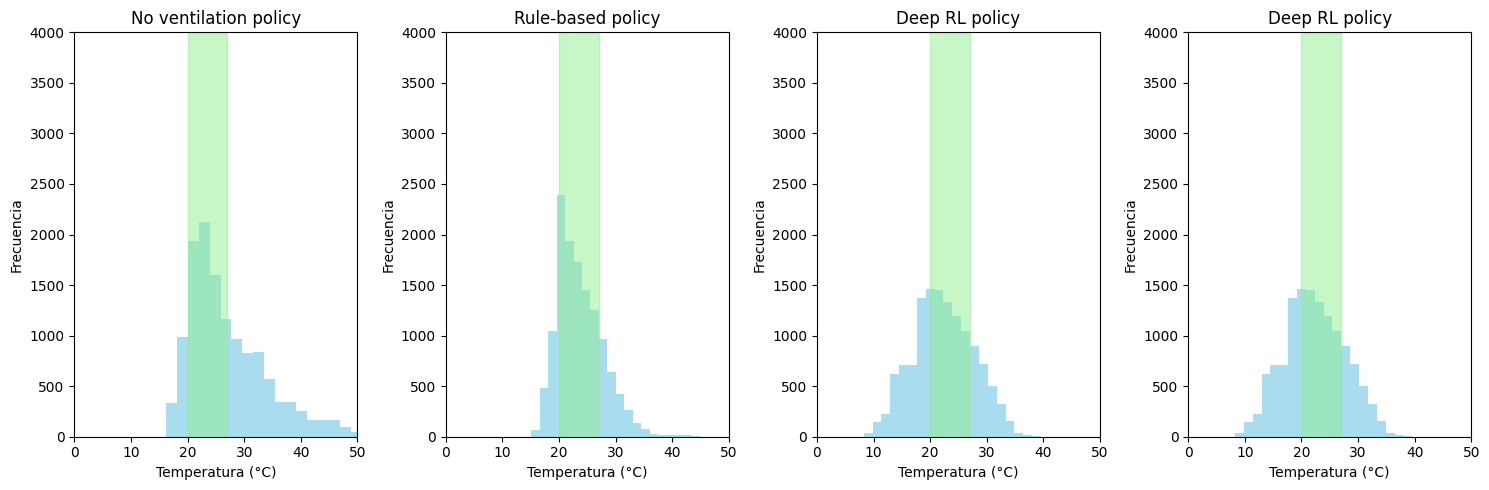

In [6]:
# Violación de rango de temperaturas de confort (27 a 20 °C).
# Histograma de distribución de temperaturas en la zona térmica y contabilización en porcentaje de 
# la cantidad de veces que se estuvo fuera del rango de confort.

# Define los rangos de temperatura de confort
rango_confort = (20, 27)  # Por ejemplo, entre 20°C y 24°C

# Grafica los histogramas
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# No Ventilation Policy
axs[0].hist(novent_data_cleaned["Zone Mean Air Temperature"], bins=20, color='skyblue', alpha=0.7)
axs[0].set_title("No ventilation policy")
axs[0].set_xlabel('Temperatura (°C)')
axs[0].set_ylabel('Frecuencia')
axs[0].set_ylim(0, 4000)
axs[0].set_xlim(0, 50)

# Marca los rangos de temperatura de confort
axs[0].axvspan(rango_confort[0], rango_confort[1], color='lightgreen', alpha=0.5)
#axs[0].axvspan(rango_confort[1], max(novent_data_cleaned["Zone Mean Air Temperature"]), color='salmon', alpha=0.5)
#axs[0].axvspan(min(novent_data_cleaned["Zone Mean Air Temperature"]), rango_confort[0], color='salmon', alpha=0.5)

# RB Policy
axs[1].hist(rb_data_cleaned["Zone Mean Air Temperature"], bins=20, color='skyblue', alpha=0.7)
axs[1].set_title("Rule-based policy")
axs[1].set_xlabel('Temperatura (°C)')
axs[1].set_ylabel('Frecuencia')
axs[1].set_ylim(0, 4000)
axs[1].set_xlim(0, 50)

# Marca los rangos de temperatura de confort
axs[1].axvspan(rango_confort[0], rango_confort[1], color='lightgreen', alpha=0.5)
#axs[1].axvspan(rango_confort[1], max(rb_data_cleaned["Zone Mean Air Temperature"]), color='salmon', alpha=0.5)
#axs[1].axvspan(min(rb_data_cleaned["Zone Mean Air Temperature"]), rango_confort[0], color='salmon', alpha=0.5)

# DRL Policy
axs[2].hist(drl_data_cleaned["Zone Mean Air Temperature"], bins=20, color='skyblue', alpha=0.7)
axs[2].set_title("Deep RL policy")
axs[2].set_xlabel('Temperatura (°C)')
axs[2].set_ylabel('Frecuencia')
axs[2].set_ylim(0, 4000)
axs[2].set_xlim(0, 50)

# Marca los rangos de temperatura de confort
axs[2].axvspan(rango_confort[0], rango_confort[1], color='lightgreen', alpha=0.5)
#axs[2].axvspan(rango_confort[1], max(drl_data_cleaned["Zone Mean Air Temperature"]), color='salmon', alpha=0.5)
#axs[2].axvspan(min(drl_data_cleaned["Zone Mean Air Temperature"]), rango_confort[0], color='salmon', alpha=0.5)

# DRL2 Policy
axs[3].hist(drl2_data_cleaned["Zone Mean Air Temperature"], bins=20, color='skyblue', alpha=0.7)
axs[3].set_title("Deep RL policy")
axs[3].set_xlabel('Temperatura (°C)')
axs[3].set_ylabel('Frecuencia')
axs[3].set_ylim(0, 4000)
axs[3].set_xlim(0, 50)

# Marca los rangos de temperatura de confort
axs[3].axvspan(rango_confort[0], rango_confort[1], color='lightgreen', alpha=0.5)
#axs[3].axvspan(rango_confort[1], max(drl_data_cleaned["Zone Mean Air Temperature"]), color='salmon', alpha=0.5)
#axs[3].axvspan(min(drl_data_cleaned["Zone Mean Air Temperature"]), rango_confort[0], color='salmon', alpha=0.5)

plt.tight_layout()
plt.show()

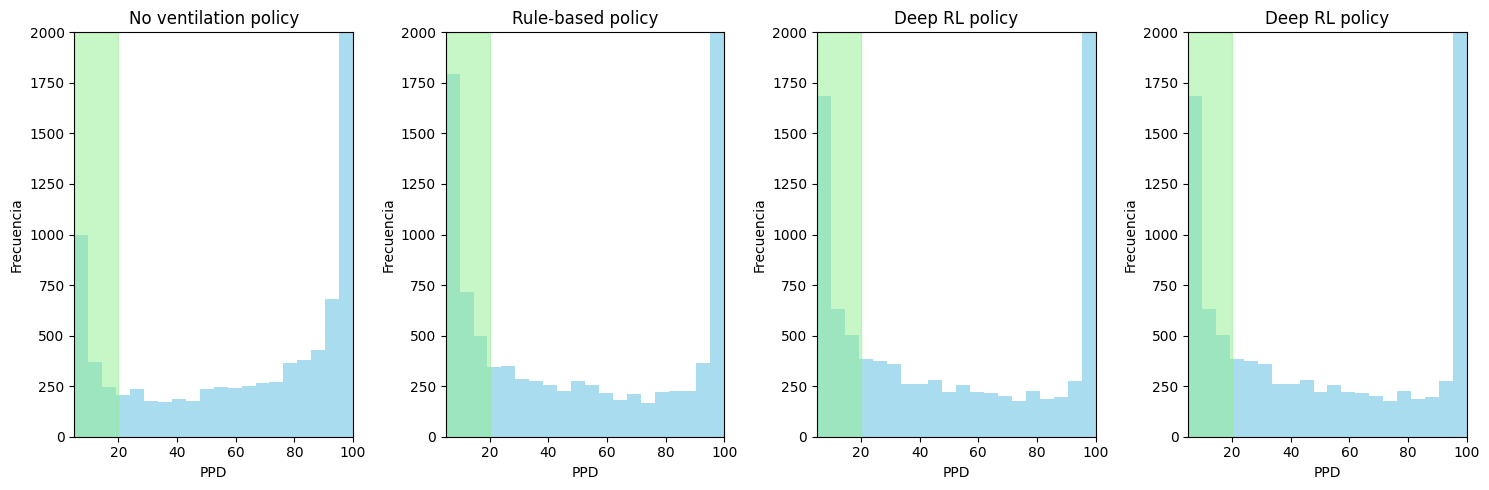

In [7]:
# Violación de rango de temperaturas de confort (27 a 20 °C).
# Histograma de distribución de temperaturas en la zona térmica y contabilización en porcentaje de 
# la cantidad de veces que se estuvo fuera del rango de confort.

# Define los rangos de temperatura de confort
rango_confort = (5, 20)  # Por ejemplo, entre 20°C y 24°C

# Grafica los histogramas
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# No Ventilation Policy
axs[0].hist(novent_data_cleaned["Zone Thermal Comfort Fanger Model PPD"], bins=20, color='skyblue', alpha=0.7)
axs[0].set_title("No ventilation policy")
axs[0].set_xlabel('PPD')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xlim(5, 100)
axs[0].set_ylim(0, 2000)

# Marca los rangos de temperatura de confort
axs[0].axvspan(rango_confort[0], rango_confort[1], color='lightgreen', alpha=0.5)
#axs[0].axvspan(rango_confort[1], max(novent_data_cleaned["Zone Mean Air Temperature"]), color='salmon', alpha=0.5)
#axs[0].axvspan(min(novent_data_cleaned["Zone Mean Air Temperature"]), rango_confort[0], color='salmon', alpha=0.5)

# RB Policy
axs[1].hist(rb_data_cleaned["Zone Thermal Comfort Fanger Model PPD"], bins=20, color='skyblue', alpha=0.7)
axs[1].set_title("Rule-based policy")
axs[1].set_xlabel('PPD')
axs[1].set_ylabel('Frecuencia')
axs[1].set_xlim(5, 100)
axs[1].set_ylim(0, 2000)

# Marca los rangos de temperatura de confort
axs[1].axvspan(rango_confort[0], rango_confort[1], color='lightgreen', alpha=0.5)
#axs[1].axvspan(rango_confort[1], max(rb_data_cleaned["Zone Mean Air Temperature"]), color='salmon', alpha=0.5)
#axs[1].axvspan(min(rb_data_cleaned["Zone Mean Air Temperature"]), rango_confort[0], color='salmon', alpha=0.5)

# DRL Policy
axs[2].hist(drl_data_cleaned["Zone Thermal Comfort Fanger Model PPD"], bins=20, color='skyblue', alpha=0.7)
axs[2].set_title("Deep RL policy")
axs[2].set_xlabel('PPD')
axs[2].set_ylabel('Frecuencia')
axs[2].set_xlim(5, 100)
axs[2].set_ylim(0, 2000)

# Marca los rangos de temperatura de confort
axs[2].axvspan(rango_confort[0], rango_confort[1], color='lightgreen', alpha=0.5)
#axs[2].axvspan(rango_confort[1], max(drl_data_cleaned["Zone Mean Air Temperature"]), color='salmon', alpha=0.5)
#axs[2].axvspan(min(drl_data_cleaned["Zone Mean Air Temperature"]), rango_confort[0], color='salmon', alpha=0.5)

# DRL2 Policy
axs[3].hist(drl2_data_cleaned["Zone Thermal Comfort Fanger Model PPD"], bins=20, color='skyblue', alpha=0.7)
axs[3].set_title("Deep RL policy")
axs[3].set_xlabel('PPD')
axs[3].set_ylabel('Frecuencia')
axs[3].set_xlim(5, 100)
axs[3].set_ylim(0, 2000)

# Marca los rangos de temperatura de confort
axs[3].axvspan(rango_confort[0], rango_confort[1], color='lightgreen', alpha=0.5)
#axs[3].axvspan(rango_confort[1], max(drl_data_cleaned["Zone Mean Air Temperature"]), color='salmon', alpha=0.5)
#axs[3].axvspan(min(drl_data_cleaned["Zone Mean Air Temperature"]), rango_confort[0], color='salmon', alpha=0.5)

plt.tight_layout()
plt.show()

Para responder la siguiente pregunta:

3. ¿Cómo afecta la política al control de sombras convencional?

se continúa utilizando el mismo entorno de evaluación, pero ahora se centra la atención en la operación de las persianas, que se ven modificadas por la influencia del comportamiento del agente.

Surge aquí una pregunta adicional ¿cómo es la política entrenada para conseguir estos ahorros de energía?

Comenzamos por analizar el tiempo de apertura de ambas ventanas durante el año.

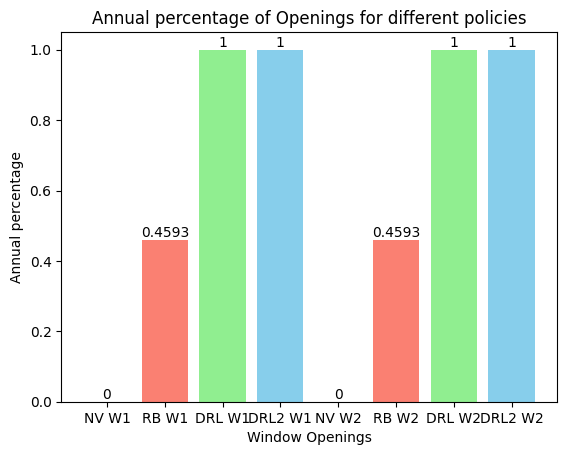

In [8]:
metrics = [
    round(novent_data_cleaned.describe()['window_opening_1']['mean'],4),
    round(rb_data_cleaned.describe()['window_opening_1']['mean'],4),
    round(drl_data_cleaned.describe()['window_opening_1']['mean'],4),
    round(drl2_data_cleaned.describe()['window_opening_1']['mean'],4),
    
    round(novent_data_cleaned.describe()['window_opening_2']['mean'],4),
    round(rb_data_cleaned.describe()['window_opening_2']['mean'],4),
    round(drl_data_cleaned.describe()['window_opening_2']['mean'],4),
    round(drl2_data_cleaned.describe()['window_opening_2']['mean'],4)
]

# Create a bar graph
categories = ['NV W1', 'RB W1', 'DRL W1', 'DRL2 W1', 'NV W2', 'RB W2', 'DRL W2', 'DRL2 W2']
values = [metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5], metrics[6], metrics[7]]

plt.bar_label(plt.bar(categories, values, color=['skyblue', 'salmon', 'lightgreen', 'skyblue', 'skyblue', 'salmon', 'lightgreen','skyblue']))
plt.xlabel('Window Openings')
plt.ylabel('Annual percentage')
plt.title('Annual percentage of Openings for different policies')
plt.show()

Es importante tener en cuenta que aquí la política utilizada para operar las sombras siempre fue la convencional, por lo que las modificaciones presentadas responden a la modificación introducida en el entorno y no a un aprendizaje de política para estos dispositivos. Como acción futura se quiere optimizar la política para el control de sombras.

Analicemos cómo es la operación temporal de las ventanas. Para ello, es mejor utilizar gráficas de línea.

In [9]:
def policy_analisys(drl_data_cleaned, rb_data_cleaned, a:int=None, b:int=None, To: bool = True):
    
    if a == None and b == None:
        drl_filtered_data=drl_data_cleaned.iloc[:]
        rb_filtered_data=rb_data_cleaned.iloc[:]
    elif a == None and b != None:
        drl_filtered_data=drl_data_cleaned.iloc[:b]
        rb_filtered_data=rb_data_cleaned.iloc[:b]
    elif a != None and b == None:
        drl_filtered_data=drl_data_cleaned.iloc[a:]
        rb_filtered_data=rb_data_cleaned.iloc[a:]
    elif a != None and b != None:
        drl_filtered_data=drl_data_cleaned.iloc[a:b]
        rb_filtered_data=rb_data_cleaned.iloc[a:b]
    
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time Steps')

    ax1.set_ylabel('Opening state')
    ax1.plot(rb_filtered_data['window_opening_1'], label='RB Window 1 opening', color='C0')
    ax1.plot(drl_filtered_data['window_opening_1'], label='DRL Window 1 opening', color='C1')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Temperature, °C')
    ax2.plot(rb_filtered_data["Zone Mean Air Temperature"], label='Zone Mean Temperature RB', color='C4')
    ax2.plot(drl_filtered_data["Zone Mean Air Temperature"], label='Zone Mean Temperature DRL', color='C5')
    if To:
        ax2.plot(drl_filtered_data['Site Outdoor Air Drybulb Temperature'], label='Site Outdoor Air Drybulb Temperature', color='C6')


    plt.title(f'Comparison of opening in the Window 1 between DRL and RB policies')
    fig.legend(bbox_to_anchor=(1., 0., 0.45, 1.))
    fig.tight_layout() 

    # Display the plot
    plt.show()

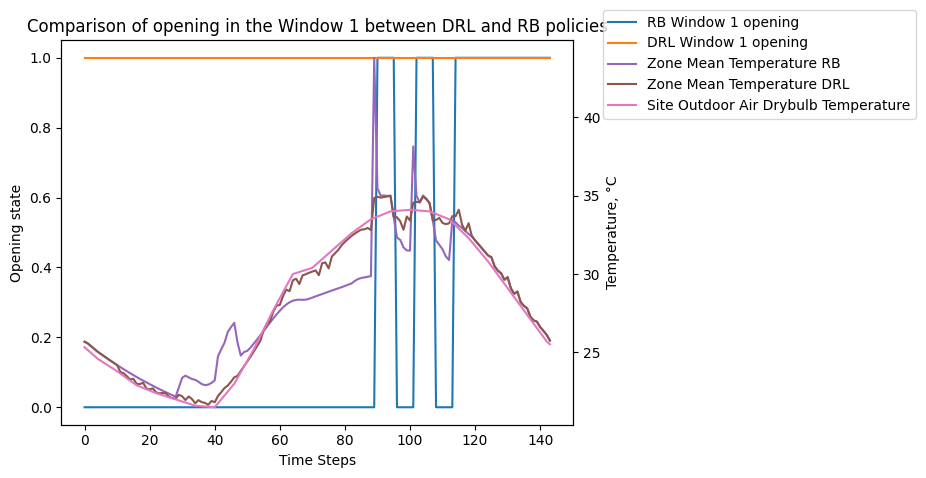

In [13]:
a = 0
b = 144

policy_analisys(drl_data_cleaned, rb_data_cleaned, a, b, To=True)

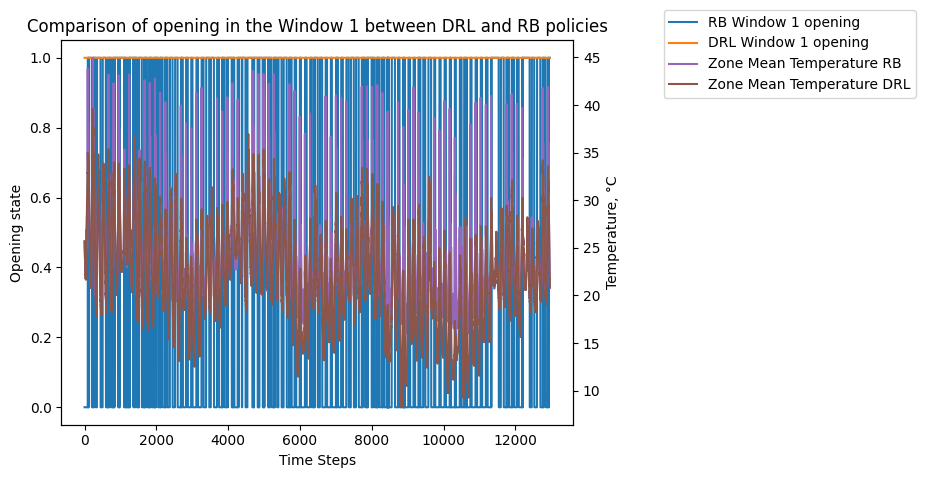

In [12]:
a = None
b = None

policy_analisys(drl_data_cleaned, rb_data_cleaned, a, b, To= False)